In [ ]:
import bcolz
import numpy as np
import pickle
import regex as re
import torch
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
# Importing GloVe Embeddings (Wikipedia Dataset)

words = []
idx = 0
word2idx = {}
vectors = bcolz.carray(np.zeros(1), rootdir=f'./6B.300.dat', mode='w')

with open(f'./glove.6B.300d.txt', 'rb') as f:
    for l in f:
        line = l.decode().split()
        word = line[0]
        words.append(word)
        word2idx[word] = idx
        idx += 1
        vect = np.array(line[1:]).astype(np.float)
        vectors.append(vect)

In [ ]:
# Storing to avoid repetitive parsing
vectors = bcolz.carray(vectors[1:].reshape((400001, 300)), rootdir=f'./6B.300.dat', mode='w')
vectors.flush()
pickle.dump(words, open('./6B.300_words.pkl', 'wb'))
pickle.dump(word2idx, open('./6B.300_idx.pkl', 'wb'))

In [ ]:
# Reading the weights and values from files

vectors = bcolz.open('./6B.300.dat')[:]
words = pickle.load(open('./6B.300_words.pkl', 'rb'))
word2idx = pickle.load(open('./6B.300_idx.pkl', 'rb'))

glove = {w: vectors[word2idx[w]] for w in words}

In [ ]:
# Word Embedding layer, using pretrained GloVe embeddings, so no training
class Embed(nn.Module):

    def __init__(self, weights_matrix):
        super(Embed, self).__init__()

        self.num_embeddings, self.embedding_dim = weights_matrix.shape
        self.emb_layer = nn.Embedding.from_pretrained(torch.FloatTensor(weights_matrix))
        self.emb_layer.weight.requires_grad = False

    def forward(self,x):
        out = self.emb_layer(x)
        return out

In [ ]:
class WordEmbedding(nn.Module):

    def __init__(self, num_embeddings, embedding_dim):
        super(WordEmbedding, self).__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.emb_layer = nn.Embedding(num_embeddings, embedding_dim)
        self.emb_layer.weight.requires_grad = True

    def forward(self, x):
        out = self.emb_layer(x)
        return out

In [ ]:
# Embedding layer for aspect embeddings (15 * 1)

class AspectEmbeddings(nn.Module):
    
    def __init__(self, num_embeddings, embedding_dim):
        super(AspectEmbeddings, self).__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.emb_layer = nn.Embedding(num_embeddings, embedding_dim)
        self.emb_layer.weight.requires_grad = True

    def forward(self, x):
        out = self.emb_layer(x)
        return out

In [ ]:
# Word level bi-directional LSTM

class WordBiLSTM(nn.Module):

    def __init__(self, input_dim, output_dim, num_layers=1, dropout=0, rnn_type=nn.LSTM):
        super(WordBiLSTM, self).__init__()

        self.input_dim = input_dim
        self.num_layers = num_layers
        self.dropout = dropout
        self.output_dim = output_dim

        # LSTM layer
        self.lstm = rnn_type(self.input_dim, self.output_dim, self.num_layers, 
        batch_first=True, bidirectional=True, dropout = self.dropout)
    
    def forward(self, x):
        
        lstm_out, (h_n, c_n) = self.lstm(x)

        return h_n

In [ ]:
# Sentence level bi-directional LSTM

class SentBiLSTM(nn.Module):

    def __init__(self, input_dim, output_dim, num_layers, dropout, rnn_type=nn.LSTM):
        super(SentBiLSTM, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.dropout = dropout

        self.lstm = rnn_type(self.input_dim, self.output_dim, self.num_layers, 
        batch_first=True, bidirectional=True, dropout = self.dropout)
    
    def forward(self,x):

        lstm_out, (h_n, c_n) = self.lstm(x)
        
        return lstm_out

In [ ]:
# Hierarchical bi-directional LSTM using the above layers
class HLSTM(nn.Module):

    def __init__(self, embedding_type = "glove"):
        super(HLSTM, self).__init__()

        if (embedding_type == "glove"):
            self.embed = Embed(weights_matrix)
        else:
            print("Initialising random word embeddings\n")
            self.embed = WordEmbedding(num_target_vocab, 300)

        self.aspectEmbed = AspectEmbeddings(num_aspect_vocab, 15)
        self.dropout = nn.Dropout(0.5)
        self.wordLSTM = WordBiLSTM(input_dim = 300, output_dim=200, num_layers=1, dropout=0, rnn_type=nn.LSTM)
        self.sentLSTM = SentBiLSTM(input_dim = 415, output_dim=200, num_layers=1, dropout=0, rnn_type=nn.LSTM)
        self.linearLayer = nn.Linear(400, 3)
        self.softMaxLayer = nn.Softmax(1)


    def forward(self, input_data, input_aspects):
        emb_out = self.embed(input_data)
        emb_out = self.dropout(emb_out)
        emb_out = emb_out.reshape((input_data.shape[0]*input_data.shape[1], num_words, 300))
        word_out = self.wordLSTM(emb_out)

        sent_in = torch.empty((0,num_max_aspects,415), requires_grad = False)

        len_list = []
        for i in range(input_data.shape[0]):
            sent_i_in = torch.empty((0,415),  requires_grad = False)

            for j in range(input_data[0].shape[0]):
                if target_vocab[int(input_data[i][j][0])] == 'EOF':
                    continue
                for k in input_aspects[i][j]:
                    if(k[0] == -1 and k[1] == -1):
                        continue
                    aspect_append = (self.aspectEmbed(torch.LongTensor([k[0]]))[0] +   self.aspectEmbed(torch.LongTensor([k[1]]))[0])/2
                    final = torch.cat((word_out[0][i*num_sentences+j], word_out[1][i*num_sentences+j], aspect_append), 0)
                    final = torch.unsqueeze(final, dim=0)

                    sent_i_in = torch.cat([sent_i_in, final], dim=0)
    
            pads = num_max_aspects - sent_i_in.shape[0]
            len_list.append(sent_i_in.shape[0])
            
            for _ in range(pads):
                ran_pad = torch.zeros(1, 415)
                sent_i_in = torch.cat([sent_i_in, ran_pad], dim=0)

            sent_i_in = torch.unsqueeze(sent_i_in, dim=0) 
            sent_in = torch.cat([sent_in, sent_i_in], dim=0)


        sent_out = self.sentLSTM(sent_in)

        sent_out  = sent_out.reshape(-1, 400)

        linear_out = self.linearLayer(sent_out)

        probability = self.softMaxLayer(linear_out)

        probability = probability.reshape(input_data.shape[0],-1,3)

        mask = torch.zeros(probability.shape) ### 415 x num_max_aspects x 3


        for i in range(len(len_list)):
            mask[i, 0:len_list[i]] = torch.ones((len_list[i], 3))

        
        probability = torch.mul(probability, mask)
        

        return probability


In [ ]:
def get_data_from_file(f1, f2, num_max_aspects, num_each_sentence_aspect):
    with open(f1, 'rb') as f:
        data = np.load(f, allow_pickle=True)
        aspects = np.load(f, allow_pickle=True)

    with open(f2, 'rb') as f:
        labels = np.load(f, allow_pickle=True) 

    target_vocab = set()

    for i in data:
        for j in i:
            for k in j:
                target_vocab.add(k)

    target_vocab = list(target_vocab)

    aspect_vocab = set()

    for i in aspects:
        for j in i:
            for k in j:
                words = k.split('#')
                for w in words:
                    aspect_vocab.add(w)

    aspect_vocab = list(aspect_vocab)

    matrix_len = len(target_vocab)
    weights_matrix = np.zeros((matrix_len, 300))
    words_found = 0
    emb_dim = 300
    for i, word in enumerate(target_vocab):
        try: 
            word = word.lower()
            word = re.sub('<.*?!,>','',word)
            weights_matrix[i] = glove[word]
            words_found += 1
        except KeyError:
            weights_matrix[i] = np.random.normal(scale=0.6, size=(emb_dim, ))

    weights_matrix = np.array(weights_matrix)


    sentiment = []
    sentiment_len = []
    for i in labels:
        sent_i = []
        for j in i:
            for k in j:
                if(k == 'negative'):
                    sent_i.append([0, 1, 0])
                elif (k == 'positive'):
                    sent_i.append([1, 0, 0])
                else:
                    sent_i.append([0, 0, 1])
        sentiment_len.append(len(sent_i))
        for k in range(len(sent_i), num_max_aspects):
            sent_i.append([0, 0, 0])      
        sentiment.append(sent_i)


    sentiment = np.array(sentiment)
    sentiment_len = np.array(sentiment_len) 

    data_X = np.zeros((data.shape[0], data.shape[1], num_words), float)
    for i in range(data.shape[0]):
        for j in range(0, data.shape[1]):
            for k in range(0, num_words):
                data_X[i][j][k] = float(target_vocab.index(data[i][j][k]))

    aspect_encodding = []
    for i in range(aspects.shape[0]):
        aspects_i = [];
        for j in range(num_sentences):
            aspects_j = [];
            for k in aspects[i][j]:
                words = k.split('#')
                if(len(words) != 2):
                    continue
                aspects_j.append([aspect_vocab.index(words[0]), aspect_vocab.index(words[1])])
            for k in range(num_each_sentence_aspect-len(aspects_j)):
                aspects_j.append([-1, -1])
            aspects_i.append(aspects_j)
        aspect_encodding.append(aspects_i)

    aspect_encodding = np.array(aspect_encodding)

    return data_X, sentiment, sentiment_len, aspect_encodding, target_vocab, aspect_vocab, weights_matrix


In [ ]:
def create_dataloaders(X, Y, Y_len, aspects):
    train_X = X[:num_reviews]
    train_Y = Y[:num_reviews]
    train_aspect = aspects[:num_reviews]
    train_aspect_len = Y_len[:num_reviews]
    train_data = TensorDataset(torch.LongTensor(train_X), torch.LongTensor(train_aspect), 
    torch.LongTensor(train_aspect_len), torch.FloatTensor(train_Y))

    test_X = X[num_reviews:]
    test_Y = Y[num_reviews:]
    test_aspect = aspects[num_reviews:]
    test_aspect_len = Y_len[num_reviews:]
    test_data = TensorDataset(torch.LongTensor(test_X), torch.LongTensor(test_aspect), 
    torch.LongTensor(test_aspect_len), torch.FloatTensor(test_Y))

    train_dataloader = DataLoader(train_data, 10)
    test_dataloader = DataLoader(test_data, 10)

    return train_dataloader, test_dataloader

In [ ]:
def train_and_evaluate(train_dataloader, test_dataloader, wordEmbeddingType="glove"):
    net = HLSTM(wordEmbeddingType)
    print(net)

    for param in net.parameters():
        print(type(param.data), param.size())

    optimizer = optim.Adam(net.parameters())
    torch.nn.utils.clip_grad_norm_(net.parameters(), 5)
    criterion = torch.nn.CrossEntropyLoss()

    # Training the network
    net.train()
    prev_epochloss = 0
    error = []
    for epoch in range(1, 100):
        print("\n-------EPOCH {}-------".format(epoch))
        epoch_loss = 0

        for (i, XY) in enumerate(train_dataloader):
            optimizer.zero_grad()
            out = net(XY[0], XY[1])
            
            loss =  criterion(out, XY[3]) 
            epoch_loss += loss.item()
            print("Iteration ",i,loss.item())
            loss.backward()
            optimizer.step()

        print("======> Epoch complete, Loss: ",epoch_loss)
        error.append(epoch_loss)
        if(np.isclose(prev_epochloss, epoch_loss)):
            break
        prev_epochloss = epoch_loss

    plt.plot(range(len(error)), error)
    plt.title("Training Error vs Epochs")
    plt.show()

    net.eval()
    test_loss = 0
    correct = 0
    total = 0

    accu = 0
    total_asp_sent = 0 

    for (i, XY) in enumerate(test_dataloader):
        optimizer.zero_grad()

        out = net(XY[0], XY[1])
        loss =  criterion(out, XY[3]) 
        test_loss += loss.item()
        print("Iteration ",i,loss.item())


        ###  accuracy

        for rev in range(XY[2].shape[0]):

            num_asp_sent = XY[2][rev]
            pred = torch.argmax(XY[3][rev, 0:num_asp_sent], dim = 1)
            gt = torch.argmax(out[rev, 0:num_asp_sent], dim = 1)

            accu += (pred.eq(gt)).sum()
            total_asp_sent += num_asp_sent


    print("Accuracy",accu/total_asp_sent)
    print("Testing loss", test_loss)



In [ ]:
num_words = 35
num_sentences = 7
X, Y, Y_len, aspects, target_vocab, aspect_vocab, weights_matrix = get_data_from_file('data.npy', 'labels.npy', 20, 5)
num_max_aspects = 20
num_reviews = 400
num_each_sentence_aspect = 5
num_target_vocab = len(target_vocab)
num_aspect_vocab = len(aspect_vocab)

In [ ]:
train_dataloader, test_dataloader = create_dataloaders(X, Y, Y_len, aspects)

HLSTM(
  (embed): Embed(
    (emb_layer): Embedding(2388, 300)
  )
  (aspectEmbed): AspectEmbeddings(
    (emb_layer): Embedding(11, 15)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (wordLSTM): WordBiLSTM(
    (lstm): LSTM(300, 200, batch_first=True, bidirectional=True)
  )
  (sentLSTM): SentBiLSTM(
    (lstm): LSTM(415, 200, batch_first=True, bidirectional=True)
  )
  (linearLayer): Linear(in_features=400, out_features=3, bias=True)
  (softMaxLayer): Softmax(dim=1)
)
<class 'torch.Tensor'> torch.Size([2388, 300])
<class 'torch.Tensor'> torch.Size([11, 15])
<class 'torch.Tensor'> torch.Size([800, 300])
<class 'torch.Tensor'> torch.Size([800, 200])
<class 'torch.Tensor'> torch.Size([800])
<class 'torch.Tensor'> torch.Size([800])
<class 'torch.Tensor'> torch.Size([800, 300])
<class 'torch.Tensor'> torch.Size([800, 200])
<class 'torch.Tensor'> torch.Size([800])
<class 'torch.Tensor'> torch.Size([800])
<class 'torch.Tensor'> torch.Size([800, 415])
<class 'torch.Tensor'> torch.Size([800

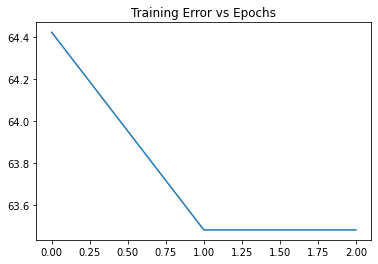

Iteration  0 1.5874438285827637
Iteration  1 2.5802345275878906
Accuracy tensor(0.8276)
Testing loss 4.167678356170654


In [ ]:
train_and_evaluate(train_dataloader, test_dataloader)

Initialising random word embeddings

HLSTM(
  (embed): WordEmbedding(
    (emb_layer): Embedding(2388, 300)
  )
  (aspectEmbed): AspectEmbeddings(
    (emb_layer): Embedding(11, 15)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (wordLSTM): WordBiLSTM(
    (lstm): LSTM(300, 200, batch_first=True, bidirectional=True)
  )
  (sentLSTM): SentBiLSTM(
    (lstm): LSTM(415, 200, batch_first=True, bidirectional=True)
  )
  (linearLayer): Linear(in_features=400, out_features=3, bias=True)
  (softMaxLayer): Softmax(dim=1)
)
<class 'torch.Tensor'> torch.Size([2388, 300])
<class 'torch.Tensor'> torch.Size([11, 15])
<class 'torch.Tensor'> torch.Size([800, 300])
<class 'torch.Tensor'> torch.Size([800, 200])
<class 'torch.Tensor'> torch.Size([800])
<class 'torch.Tensor'> torch.Size([800])
<class 'torch.Tensor'> torch.Size([800, 300])
<class 'torch.Tensor'> torch.Size([800, 200])
<class 'torch.Tensor'> torch.Size([800])
<class 'torch.Tensor'> torch.Size([800])
<class 'torch.Tensor'> torch.Size([800,

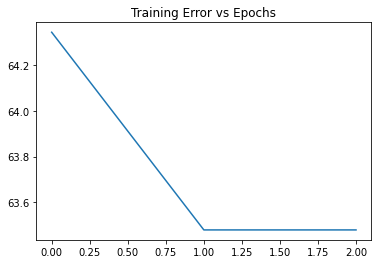

Iteration  0 1.5874439477920532
Iteration  1 2.580235004425049
Accuracy tensor(0.8276)
Testing loss 4.167678952217102


In [ ]:
train_and_evaluate(train_dataloader, test_dataloader, "random")

In [ ]:
num_words = 71
num_sentences = 47
X, Y, Y_len, aspects, target_vocab, aspect_vocab, weights_matrix = get_data_from_file('data_restaurants_521_47_70_merge.npy',
 'labels_restaurants_521_merge.npy', 47, 1)
num_max_aspects = 47
num_reviews = 500
num_each_sentence_aspect = 1
num_target_vocab = len(target_vocab)
num_aspect_vocab = len(aspect_vocab)

In [ ]:
train_dataloader, test_dataloader = create_dataloaders(X, Y, Y_len, aspects)

HLSTM(
  (embed): Embed(
    (emb_layer): Embedding(8494, 300)
  )
  (aspectEmbed): AspectEmbeddings(
    (emb_layer): Embedding(39, 15)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (wordLSTM): WordBiLSTM(
    (lstm): LSTM(300, 200, batch_first=True, bidirectional=True)
  )
  (sentLSTM): SentBiLSTM(
    (lstm): LSTM(415, 200, batch_first=True, bidirectional=True)
  )
  (linearLayer): Linear(in_features=400, out_features=3, bias=True)
  (softMaxLayer): Softmax(dim=1)
)
<class 'torch.Tensor'> torch.Size([8494, 300])
<class 'torch.Tensor'> torch.Size([39, 15])
<class 'torch.Tensor'> torch.Size([800, 300])
<class 'torch.Tensor'> torch.Size([800, 200])
<class 'torch.Tensor'> torch.Size([800])
<class 'torch.Tensor'> torch.Size([800])
<class 'torch.Tensor'> torch.Size([800, 300])
<class 'torch.Tensor'> torch.Size([800, 200])
<class 'torch.Tensor'> torch.Size([800])
<class 'torch.Tensor'> torch.Size([800])
<class 'torch.Tensor'> torch.Size([800, 415])
<class 'torch.Tensor'> torch.Size([800

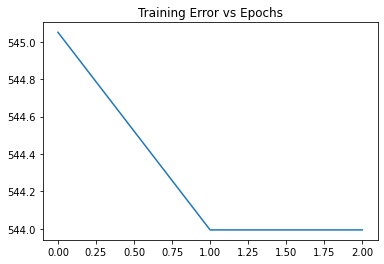

Iteration  0 14.640359878540039
Iteration  1 13.169514656066895
Accuracy tensor(0.5991)
Testing loss 27.809874534606934


In [ ]:
train_and_evaluate(train_dataloader, test_dataloader)

Initialising random word embeddings

HLSTM(
  (embed): WordEmbedding(
    (emb_layer): Embedding(8494, 300)
  )
  (aspectEmbed): AspectEmbeddings(
    (emb_layer): Embedding(39, 15)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (wordLSTM): WordBiLSTM(
    (lstm): LSTM(300, 200, batch_first=True, bidirectional=True)
  )
  (sentLSTM): SentBiLSTM(
    (lstm): LSTM(415, 200, batch_first=True, bidirectional=True)
  )
  (linearLayer): Linear(in_features=400, out_features=3, bias=True)
  (softMaxLayer): Softmax(dim=1)
)
<class 'torch.Tensor'> torch.Size([8494, 300])
<class 'torch.Tensor'> torch.Size([39, 15])
<class 'torch.Tensor'> torch.Size([800, 300])
<class 'torch.Tensor'> torch.Size([800, 200])
<class 'torch.Tensor'> torch.Size([800])
<class 'torch.Tensor'> torch.Size([800])
<class 'torch.Tensor'> torch.Size([800, 300])
<class 'torch.Tensor'> torch.Size([800, 200])
<class 'torch.Tensor'> torch.Size([800])
<class 'torch.Tensor'> torch.Size([800])
<class 'torch.Tensor'> torch.Size([800,

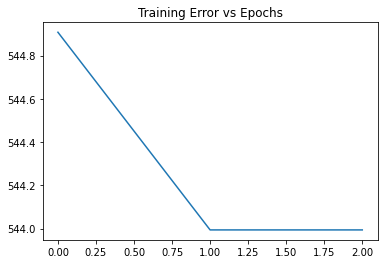

Iteration  0 14.640359878540039
Iteration  1 13.169514656066895
Accuracy tensor(0.5991)
Testing loss 27.809874534606934


In [ ]:
train_and_evaluate(train_dataloader, test_dataloader, "random")

In [ ]:
num_words = 75
num_sentences = 44
X, Y, Y_len, aspects, target_vocab, aspect_vocab, weights_matrix = get_data_from_file('data_laptop_357.npy',
 'labels_laptops_357.npy', 44, 1)
num_max_aspects = 44
num_reviews = 350
num_each_sentence_aspect = 1
num_target_vocab = len(target_vocab)
num_aspect_vocab = len(aspect_vocab)

In [ ]:
train_dataloader, test_dataloader = create_dataloaders(X, Y, Y_len, aspects)

HLSTM(
  (embed): Embed(
    (emb_layer): Embedding(6076, 300)
  )
  (aspectEmbed): AspectEmbeddings(
    (emb_layer): Embedding(42, 15)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (wordLSTM): WordBiLSTM(
    (lstm): LSTM(300, 200, batch_first=True, bidirectional=True)
  )
  (sentLSTM): SentBiLSTM(
    (lstm): LSTM(415, 200, batch_first=True, bidirectional=True)
  )
  (linearLayer): Linear(in_features=400, out_features=3, bias=True)
  (softMaxLayer): Softmax(dim=1)
)
<class 'torch.Tensor'> torch.Size([6076, 300])
<class 'torch.Tensor'> torch.Size([42, 15])
<class 'torch.Tensor'> torch.Size([800, 300])
<class 'torch.Tensor'> torch.Size([800, 200])
<class 'torch.Tensor'> torch.Size([800])
<class 'torch.Tensor'> torch.Size([800])
<class 'torch.Tensor'> torch.Size([800, 300])
<class 'torch.Tensor'> torch.Size([800, 200])
<class 'torch.Tensor'> torch.Size([800])
<class 'torch.Tensor'> torch.Size([800])
<class 'torch.Tensor'> torch.Size([800, 415])
<class 'torch.Tensor'> torch.Size([800

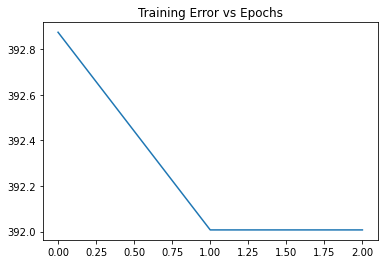

Iteration  0 15.323147773742676
Accuracy tensor(0.1609)
Testing loss 15.323147773742676


In [ ]:
train_and_evaluate(train_dataloader, test_dataloader)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d25c4a3c-cf63-4cdf-b757-db6bd5e8f60e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>